# CS 525 Assignment 1

In [1]:
import numpy as np
from Bio import SeqIO

import matplotlib.pyplot as plt

### Machine learning for protein sequence data

In this assignment you will explore the approach of modeling sequence data using feature representations based on k-mer composition.  Our data will come from the SCOP database, which is a curated repository of proteins classified according to the overall characteristics of their 3-d structure.  We will explore how well this information can be predicted from the amino acid sequence.

The primary tool we will use is the k-mer composition vector, which represents a protein in the space of all k-mers of length $k$.


### Preliminaries:  data

In this assignment you will create classifiers that predict the SCOP family a sequence belongs to.  The [SCOP database](https://scop.mrc-lmb.cam.ac.uk/) classifies sequences into families based on the characteristics of their 3-d structure.  The identifier of a SCOP family has four component, and is of the form **w.x.y.z**, representing the class.fold.superfamily.family levels of organization in SCOP (e.g. b.1.1.0).
These four levels of classification used by SCOP are:  
* family:  a group of closely related proteins
* superfamily:  groups together several families of proteins that likely share a common evolutionary origin
* fold:  groups together superfamilies based on structural properties
* class:  combine folds with common secondary secondary structure.  These include all-alpha and all-beta proteins, containing predominantly alpha-helices and beta-strands, respectively, and ‘mixed’ alpha and beta classes (a/b) and (a+b) with respectively alternating and segregated alpha-helices and beta-strands.

In your experiments you will focus on good sized families: 'c.2.1.2' and 'c.2.1.0' which are proteins with a mix of alpha helix and beta sheet secondary structures, and hence the "c".  Both families belong to the c.2.1 superfamily of NAD(P) binding proteins.  You can obtain the sequences from the following fasta file:

https://scop.berkeley.edu/downloads/scopeseq-2.08/astral-scopedom-seqres-gd-sel-gs-bib-95-2.08.fa

The file contains the sequences in version 2.08 of SCOP, processed to contain a non-redundant set of sequences such that no two sequences share more than 95% sequence identity.  This file contains the entire set of sequences, and you will need to extract from it those sequences that belong to the two classes we are interested in.


### Sparse arrays

As you have seen in class, k-mer composition can lead to sparse feature representations.  As a result, standard arrays are not ideal for storing such data.  The scipy package provides implementations of several classes of sparse arrays in the [sparse module](https://docs.scipy.org/doc/scipy/reference/sparse.html).
To create our sparse array it will be convenient to first use the [dok_array](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_array.html#scipy.sparse.dok_array) sparse array which provides convenient functionality for incremental creation of the array.  We will then convert it to the format that scikit-learn likes.

In [2]:
from scipy import sparse

# create a 2 x 5 empty sparse array
x = sparse.dok_array((2,5))
x

<Dictionary Of Keys sparse array of dtype 'float64'
	with 0 stored elements and shape (2, 5)>

Next we can populate the array with elements:

In [3]:
x[0,1]=1
x[1,2]=1
x

<Dictionary Of Keys sparse array of dtype 'float64'
	with 2 stored elements and shape (2, 5)>

Let's verify that the array looks as we would expect by converting it to a regular array:


In [4]:
x.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

scikit-learn cannot work with this array format, so we need to convert it to a Compressed Sparse Row or CSR array:

In [5]:
X = x.tocsr()
X

<Compressed Sparse Row sparse array of dtype 'float64'
	with 2 stored elements and shape (2, 5)>

This format of sparse array supports efficient computation of dot products, which is what is needed for training an SVM.  As a a sidenote, the scipy array gets converted to the C++ data structure used by the SVM solver used in scikit-learn.

In [6]:
from sklearn import svm

s = svm.SVC()
y = np.array([0, 1])
s.fit(X, y)

SVC()

### Part 1:  initial explorations with k-mer composition

Throughout the assignment we will work with k-mer composition as features for representing protein sequences.  We will define k-mer composition as a vector that specifies the number of times each k-mer of length $k$ occurs in the sequence.


In this first part of the assignment we will explore the effect of the choice of kernel (linear vs Gaussian).  We will do this for a fixed value of the k-mer size, $k=3$.  After we have found good choices for the kernel and pre-processing, we will explore performance as a function of $k$ in the next part of the assignment.


#### Baseline and data normalization.

Like other weight-vector based classifiers, SVMs benefit from appropriate normalization of the data.  Since k-mer composition data is sparse, standardization is not a good option.  Instead, we will convert the k-mer composition vectors into unit vectors.
This is done by dividing each row in the feature matrix by its norm.
Recall that Euclidean the norm of a $d$ dimensional vector $\mathbf{x}$ is defined by:
$
||\mathbf{x}||^2 = \sum_{i=1}^d x_i^2.
$
You can verify that after this operation each row in the feature matrix has unit norm.

As a baseline, compute the accuracy of a linear SVM on the normalized feature vectors.
Classifier hyper-parameters (the value of $C$) should be chosen using grid search.
Since the dataset is not very large, nested cross-validation as performed in our first exercise is a good approach approach.  Since the dataset is not as small, you can opt for five-fold cross-validation rather than ten-fold as we have done previously.

Since the data is somewhat unbalanced, use the [area under the precision recall curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) to measure classifier accuracy.


In [7]:
# Load in data
path = r'C:\Users\Jack\Documents\GitHub\CS525-Bioinformatics\astral-scopedom-seqres-gd-sel-gs-bib-95-2.08.fa'
fasta_sequences = SeqIO.parse(open(path),'fasta')

names = []
sequences = []
descriptions = []
scop = []
for fasta in fasta_sequences:
    name, sequence, description = fasta.id, str(fasta.seq), str(fasta.description)
    names.append(name)
    sequences.append(sequence)
    descriptions.append(description)
    scop.append(description.split(' ')[1])



In [8]:
i = 30000
print(names[i])
print(sequences[i])
print(descriptions[i])
print(scop[i])
print(f'Number of sequences: {len(sequences)}')


d2nn5a1
mkdtfrlenqtiyfgteraisaspqtiwryltetdklkqwfpeleigelgvngfwrfilpdfeetmpftdyaeekylgvtwdtgiiyfdlkeqaphqtllvfseslpenfttprhkdiagwsivlnrlkqvvetpdaapekidfpqienhylekltnlen
d2nn5a1 d.129.3.5 (A:1-160) Hypothetical protein EF2215 {Enterococcus faecalis [TaxId: 1351]}
d.129.3.5
Number of sequences: 35494


In [9]:
# filter data so that 'c.2.1.2' and 'c.2.1.0' are the only proteins
cls_types = ['c.2.1.2', 'c.2.1.0']
Y = []
good_index = []

for i, cls in enumerate(scop): # I know I shouldn't use cls
    if cls in cls_types:
        Y.append(cls_types.index(cls))
        good_index.append(i)

names = [names[i] for i in good_index]
sequences = [sequences[i] for i in good_index]
descriptions = [descriptions[i] for i in good_index]
scop = [scop[i] for i in good_index]
Y = np.array(Y)
num_seq = len(sequences)
print(f'new number of sequence {num_seq}')


new number of sequence 606


In [10]:
# generate the set of kmers
k = 3
kmers = [S[i:i+k] for S in sequences for i in range(len(S) - k + 1)] # Note: for loops go from outside loop to inside
print(f'All kmers: {len(kmers)}')
kmers = set(kmers)
num_kmers = len(kmers)
print(f'unique set of kmers: {num_kmers}')


All kmers: 147980
unique set of kmers: 7554


In [11]:
# count the number of occurances of each kmer (sparse matrix)
X = sparse.dok_array((num_seq, num_kmers))

kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

for i_s, S in enumerate(sequences): # fixed this it now works well
    kmer_counts = {mer: 0 for mer in kmers}
    kmers_foreachS = [S[i:i+k] for i in range(len(S) - k + 1)]
    for mer in kmers_foreachS:
        kmer_counts[mer] += 1
    for mer, count in kmer_counts.items():                      
        X[i_s, kmer_index[mer]] = count



In [12]:
# Normalize 
X = X.toarray()
print(np.linalg.norm(X[0, :])) 

epsilon = 1e-10
X = X / (np.linalg.norm(X, axis=1, keepdims=True) + epsilon)

print(np.linalg.norm(X[0, :]))

17.88854381999832
0.99999999999441


In [13]:
print(f'X Shape {X.shape}')
print(f'Y Shape {Y.shape}')

X Shape (606, 7554)
Y Shape (606,)


#### Comparison to Gaussian kernel and random forests

Compare the linear SVM with a Gaussian kernel for the normalized k-mer composition representation with $k=3$.  As before, classifier hyper-parameters should be chosen using grid search.
Is there a kernel that seems to work better?  Use it for the rest of your experiments.
Finally, compare your SVM results with a random forests classifier.

Number of Trees: 1, Train accuracy: 0.8866918708203112, Test accuracy: 0.6582786885245901
Time taken for 1 trees: 0.32758069038391113 seconds
Number of Trees: 2, Train accuracy: 0.8615713949658902, Test accuracy: 0.5774863387978142
Time taken for 2 trees: 0.38840723037719727 seconds
Number of Trees: 5, Train accuracy: 0.9739634371744463, Test accuracy: 0.7475956284153005
Time taken for 5 trees: 0.5523598194122314 seconds
Number of Trees: 10, Train accuracy: 0.9946836038579159, Test accuracy: 0.7853005464480873
Time taken for 10 trees: 0.8691372871398926 seconds
Number of Trees: 50, Train accuracy: 1.0, Test accuracy: 0.8135519125683061
Time taken for 50 trees: 3.11698055267334 seconds
Number of Trees: 100, Train accuracy: 1.0, Test accuracy: 0.8052459016393442
Time taken for 100 trees: 6.053130149841309 seconds
Number of Trees: 300, Train accuracy: 1.0, Test accuracy: 0.810136612021858
Time taken for 300 trees: 17.672816276550293 seconds
Number of Trees: 500, Train accuracy: 1.0, Test 

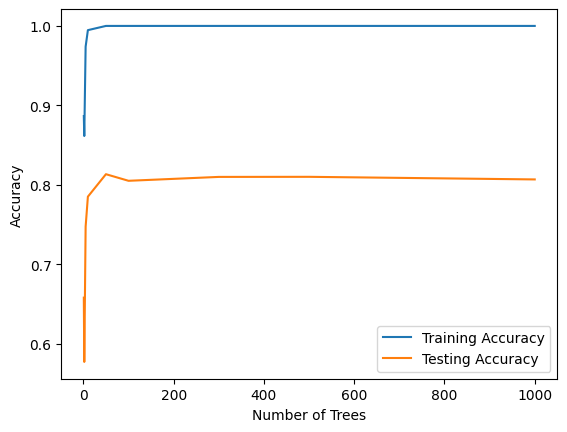

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import time


num_of_trees = [1,2,5,10,50,100,300,500,1000]
score = []
train_accuracy = []
test_accuracy = []

for n in num_of_trees:
    tree = RandomForestClassifier(n_estimators=n)
    cv = StratifiedKFold(n_splits=10, shuffle=True)
    
    train_scores = []
    test_scores = []
    
    start_time = time.time()

    for train_index, test_index in cv.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        tree.fit(X_train, y_train)
        
        train_scores.append(tree.score(X_train, y_train))
        test_scores.append(tree.score(X_test, y_test))

    train_accuracy.append(np.mean(train_scores))
    test_accuracy.append(np.mean(test_scores))

    print(f"Number of Trees: {n}, Train accuracy: {train_accuracy[-1]}, Test accuracy: {test_accuracy[-1]}")

    end_time = time.time()
    print(f"Time taken for {n} trees: {end_time - start_time} seconds")

plt.plot(num_of_trees, train_accuracy, label='Training Accuracy')
plt.plot(num_of_trees, test_accuracy, label='Testing Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




X training shape  (303, 7554)
X testing shape  (303, 7554)
Y training shape  (303,)
Y testing shape  (303,)
guassian classifier:  {'C': 10, 'gamma': 0.1}
linear classifier:  {'C': 10}
Tree classifier:  {'n_estimators': 500}


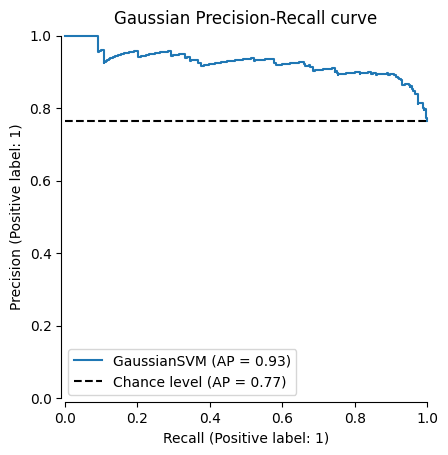

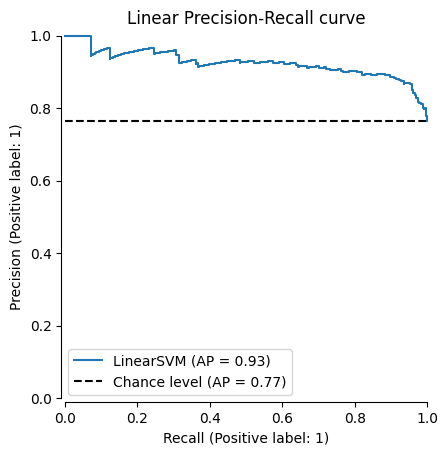

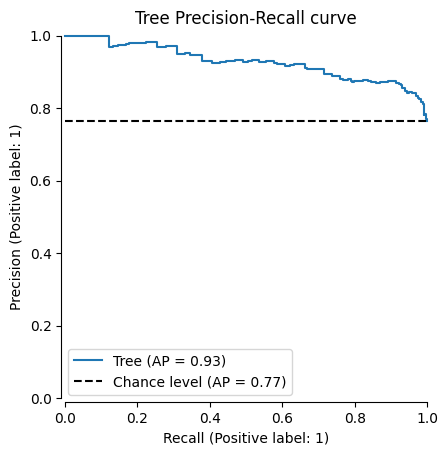

In [15]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split


cv = StratifiedKFold(n_splits=5, shuffle=True)
param_grid_gaussian = [
  {'C': [0.1, 1, 10, 100, 1000], 
   'gamma': [0.0001, 0.001, 0.01, 0.1]},
 ]

param_grid_linear = [
  {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
 ]

param_grid_tree = [
    {'n_estimators': [1,2,5,10,50,100,300,500,1000]}
]

gaussian = GridSearchCV(svm.SVC(kernel='rbf'), param_grid_gaussian, cv=cv)
linear = GridSearchCV(svm.SVC(kernel='linear'), param_grid_linear, cv=cv)
tree = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_tree, cv=cv)

# linear.fit(X,Y)
# gaussian.fit(X, Y)
# tree.fit(X,Y)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=0
)
print('X training shape ', X_train.shape)
print('X testing shape ', X_test.shape)
print('Y training shape ', Y_train.shape)
print('Y testing shape ', Y_test.shape)

linear.fit(X_train, Y_train)
gaussian.fit(X_train, Y_train)
tree.fit(X_train, Y_train)

print('guassian classifier: ', gaussian.best_params_)
print('linear classifier: ', linear.best_params_)
print('Tree classifier: ', tree.best_params_)

display = PrecisionRecallDisplay.from_estimator(
    gaussian, X_test, Y_test, name="GaussianSVM", plot_chance_level=True, despine=True
)
_ = display.ax_.set_title("Gaussian Precision-Recall curve")

display = PrecisionRecallDisplay.from_estimator(
    linear, X_test, Y_test, name="LinearSVM", plot_chance_level=True, despine=True
)
_ = display.ax_.set_title("Linear Precision-Recall curve")

display = PrecisionRecallDisplay.from_estimator(
    tree, X_test, Y_test, name="Tree", plot_chance_level=True, despine=True
)
_ = display.ax_.set_title("Tree Precision-Recall curve")



##### Response:  
All of these models seem to preform equally well on a kmer size of 3. This makes sense because with only 3 kmer, your knowledge of the structure is fairly limited. It is also sparse making this a difficult problem.

Interestingly this process is random to some extent and the gaussian seems to preform slightly better due to its AP

### Part 2:  performance as a function of k-mer size

Compute the accuracy of the linear SVM as a function the k-mer size, $k$ starting with $k=1$.  Go as high as memory will reasonably allow.

What value of the k-mer size gives you the best accuracy?
Accuracy should increase, and depending on how high of a value of $k$ you are able to use, it will begin to decrease.
Explain why you think this behavior is occuring.
For each value of $k$, compute the dot-product matrix and visualize it.
I recommend a grayscale visualization with 
```Python
plt.imshow(K, cmap='Greys');
```
where $K$ is the matrix of dot products.
Note that for a dataset with $N$ training examples, this will be an $N \times N$ matrix.  The entry $i,j$ of $K$ is equal to the dot product $\mathbf{x}_i^T \mathbf{x}_j$, where $\mathbf{x}_i$ is the feature vector of the $i$ th protein in the dataset.  Keep in mind that the computation can be performed in one line of NumPy code with no for loops!
Before computing the matrix, **make sure the data is ordered according to the class labels**.  What patterns do you observe, and can that help you in understanding the performance of the resulting SVMs?

In [16]:
def try_a_k(k):
    print(f'=================== kmers of lenght: {k} ===================')
    # Find optimum parameters for each classifier
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    kmers = [S[i:i+k] for S in sequences for i in range(len(S) - k + 1)] # Note: for loops go from outside loop to inside
    print(f'All kmers: {len(kmers)}')
    kmers = set(kmers)
    num_kmers = len(kmers)
    print(f'unique set of kmers: {num_kmers}')

    # count the number of occurances of each kmer (sparse matrix)
    X = sparse.dok_array((num_seq, num_kmers))

    kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

    for i_s, S in enumerate(sequences): # fixed this it now works well
        kmer_counts = {mer: 0 for mer in kmers}
        kmers_foreachS = [S[i:i+k] for i in range(len(S) - k + 1)]
        for mer in kmers_foreachS:
            kmer_counts[mer] += 1
        for mer, count in kmer_counts.items():                      
            X[i_s, kmer_index[mer]] = count
    

    param_grid_gaussian = [
    {'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [0.0001, 0.001, 0.01, 0.1]},
    ]
    param_grid_linear = [
    {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    ]
    param_grid_tree = [
        {'n_estimators': [1,2,5,10,50,100,300,500,1000]}
    ]

    gaussian = GridSearchCV(svm.SVC(kernel='rbf'), param_grid_gaussian, cv=cv)
    linear = GridSearchCV(svm.SVC(kernel='linear'), param_grid_linear, cv=cv)
    tree = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_tree, cv=cv)

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.5, random_state=0
    )

    linear.fit(X_train, Y_train)
    gaussian.fit(X_train, Y_train)
    tree.fit(X_train, Y_train)

    # display the PrecisionRecallDisplay
    display = PrecisionRecallDisplay.from_estimator(
        gaussian, X_test, Y_test, name="GaussianSVM", plot_chance_level=True, despine=True
    )
    _ = display.ax_.set_title("Gaussian Precision-Recall curve")
    plt.show()

    display = PrecisionRecallDisplay.from_estimator(
        linear, X_test, Y_test, name="LinearSVM", plot_chance_level=True, despine=True
    )
    _ = display.ax_.set_title("Linear Precision-Recall curve")
    plt.show()

    display = PrecisionRecallDisplay.from_estimator(
        tree, X_test, Y_test, name="Tree", plot_chance_level=True, despine=True
    )
    _ = display.ax_.set_title("Tree Precision-Recall curve")
    plt.show()
    print('completed: kmers of lenght {k}')


=================== kmers of lenght: 1 ===================
All kmers: 149192
unique set of kmers: 21


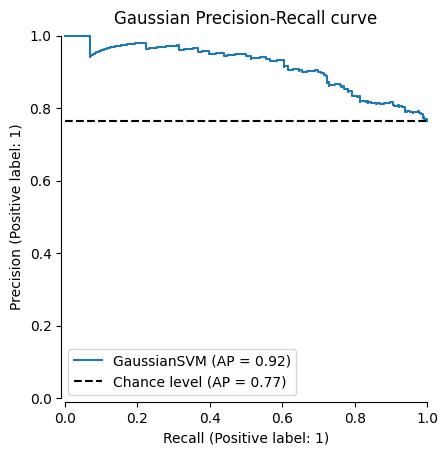

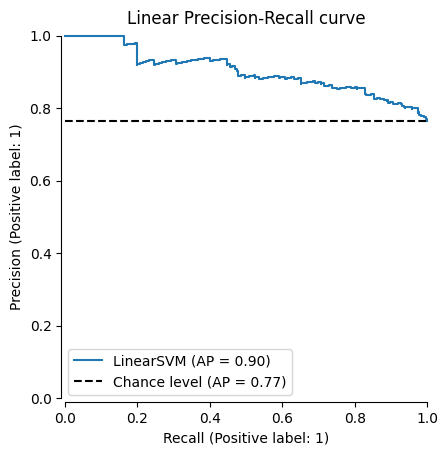

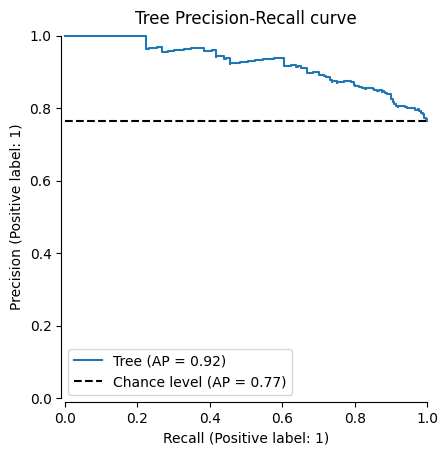

completed: kmers of lenght {k}
=================== kmers of lenght: 3 ===================
All kmers: 147980
unique set of kmers: 7554


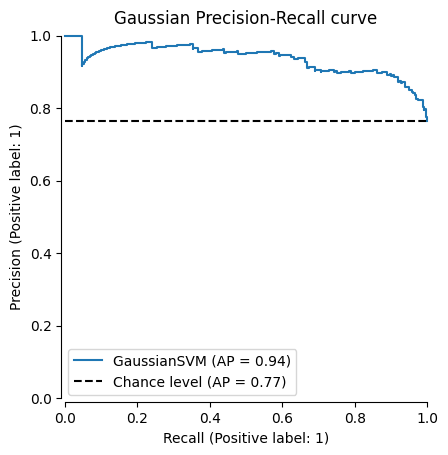

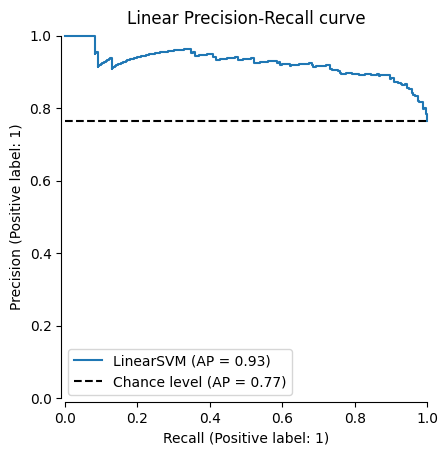

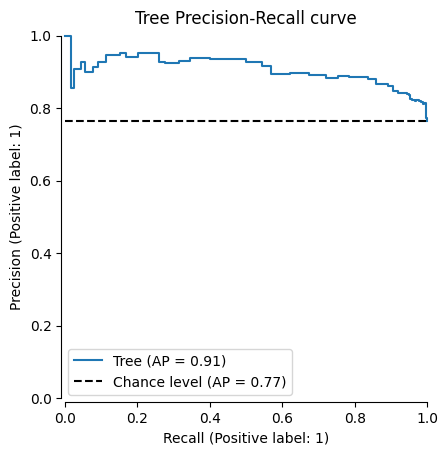

completed: kmers of lenght {k}
=================== kmers of lenght: 5 ===================
All kmers: 146768
unique set of kmers: 110067


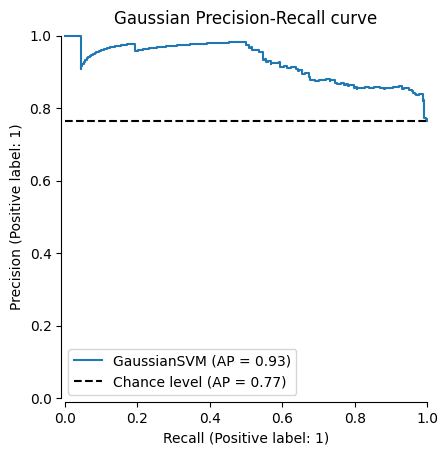

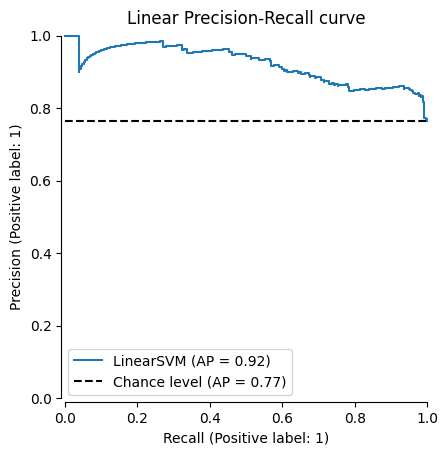

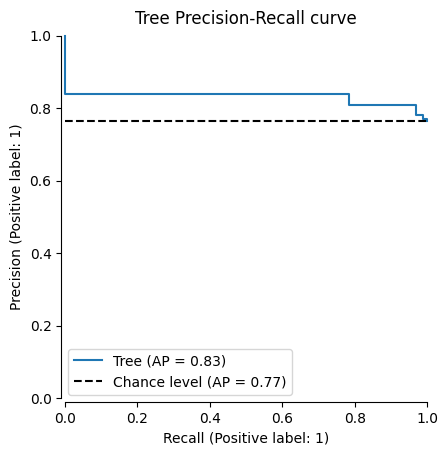

completed: kmers of lenght {k}


In [17]:
K = [1, 3, 5]
for k in K:
    try_a_k(k)

In [18]:
# Sort 
sorted_indices = np.argsort(Y)
X_sorted = X[sorted_indices]
Y_sorted = Y[sorted_indices]

print(f'Sorted Y: {Y_sorted}')
print(f'Sorted X shape: {X_sorted.shape}')


Sorted Y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 

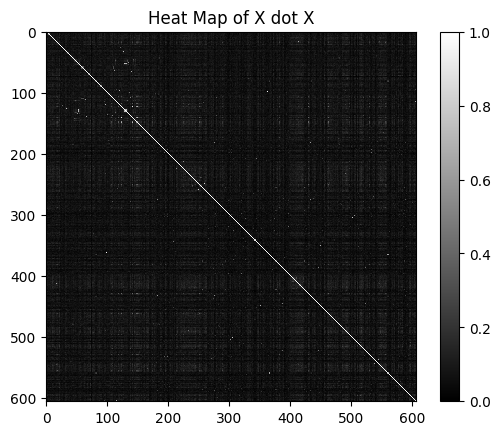

In [19]:
import matplotlib.pyplot as plt

# Compute the dot product matrix
K = np.dot(X, X.T)

# Display the heat map
plt.imshow(K, cmap='grey', interpolation='nearest')
plt.colorbar()
plt.title('Heat Map of X dot X')
plt.show()

#### Response:  

My computer could only handle 5 kmers, I probably could have gone larger but this took a while as is.  

From the dot products, this is obviously a very hard problem. There are not too many destinquishable patterns, at least by my eye. There are a few regions that do have patterns but they are faint. in the future it would be interesting to look at the rest of the data especially outside of 'groups' (i.e. family, superfamily, fold, class).  

The gaussian with optimum parameters seems to preform the best over all of the different kmer sizes. Weirdly, length 3 kmers preform the best but only marginally, I would expect more kmers (i.e. length 5 kmers) to preform better. Interestingly, the tree preforms poorly with length 5 kmers